## Meteo Bakery - Combine datasets
This notebook serves to combine df_full data with the weather summary statistics.

### import libraries

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain

### load data

In [44]:
# load df_full data
sales = pd.read_excel('../data/neueFische_Umsaetze_Baeckerei.xlsx')

In [45]:
# load data on engineered weather features
weather_stats = pd.read_csv('../data/summary_stats.csv')

In [46]:
# load holidays data

# school holidays from https://www.schulferien.org/oesterreich/ferien/2012/
school_hols = pd.read_excel("../data/school_holidays.xlsx")

# public holidays from google search "Feiertage Wien 'YEAR'"
public_hols = pd.read_excel("../data/public_holidays.xlsx")
public_hols.date = pd.to_datetime(public_hols.date)

/var/folders/jq/n1sfhk3x081brcshwchpd9640000gn/T/ipykernel_21203/3325082671.py:7: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  public_hols = pd.read_excel("../data/public_holidays.xlsx")


In [47]:
# load Corona data
corona = pd.read_excel("../data/corona-measures-vienna.xlsx")

### Feature Engineering - Sales

In [48]:
# get basic information on datatypes and missings
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52895 entries, 0 to 52894
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Branch               52895 non-null  int64         
 1   Date                 52895 non-null  datetime64[ns]
 2   PredictionGroupName  52895 non-null  object        
 3   SoldTurnver          52892 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [49]:
# generate location column based on branch
# Filiale 1: U-Bahn
# Filiale 2: Innenstadt
# Filiale 3: Bahnhof

sales['Branch'] = sales.Branch.apply(lambda x: 'Metro' if x==1 else 'Center' if x==2 else 'Train_Station')
sales.head()

,Branch,Date,PredictionGroupName,SoldTurnver
0,Metro,2012-01-01,Mischbrote,134.735759
1,Metro,2012-01-01,Weizenbrötchen,150.104897
2,Metro,2012-01-01,klassischer Kuchen,322.635866
3,Metro,2012-01-01,handliches Gebäck,1047.327119
4,Metro,2012-01-01,herzhafter Snack,816.663466


There are three missing values in the sales data ('SoldTurnver').

In [50]:
sales.columns

Index(['Branch', 'Date', 'PredictionGroupName', 'SoldTurnver'], dtype='object')

In [51]:
# rename columns
sales.rename(columns={'Branch': 'branch', 'PredictionGroupName': 'product', 'SoldTurnver': 'turnover'}, inplace=True)

In [52]:
sales.rename(columns={'Date': 'date'}, inplace=True)
sales.head()

,branch,date,product,turnover
0,Metro,2012-01-01,Mischbrote,134.735759
1,Metro,2012-01-01,Weizenbrötchen,150.104897
2,Metro,2012-01-01,klassischer Kuchen,322.635866
3,Metro,2012-01-01,handliches Gebäck,1047.327119
4,Metro,2012-01-01,herzhafter Snack,816.663466


In [53]:
#relabel products
sales['product'] = sales['product'].map({'Mischbrote':'Brown Bread',
                                'Weizenbrötchen':'Wheat Rolls',
                                'klassischer Kuchen':'Cakes',
                                'handliches Gebäck':'Pastries',
                                'herzhafter Snack':'Savoury Snack'})

In [54]:
# count dates per branch and product category
sales.groupby(['branch', 'product'])['date'].count()

branch         product      
Center         Brown Bread      3478
               Cakes            3481
               Pastries         3481
               Savoury Snack    3480
               Wheat Rolls      3481
Metro          Brown Bread      3547
               Cakes            3550
               Pastries         3550
               Savoury Snack    3550
               Wheat Rolls      3550
Train_Station  Brown Bread      3547
               Cakes            3550
               Pastries         3550
               Savoury Snack    3550
               Wheat Rolls      3550
Name: date, dtype: int64

As can be seen, not all dates are equally represented per group. This indicates that dates are not continuously progressing, but that there gaps present in the dates. Thus, there must be missing dates. Indeed, the first Covid19 lockdown has already removed from the data, representing one of possibly more gaps.

### Generate a time series of consecutive dates as backbone
To avoid such gaps, we will first generate a datetime column with consecutive gaps starting and ending with the first and last registered date. The other data will then be merged into that continuous date column, with gaps in certain columns being filled up with NaNs. These NaNs can be handled strategically during later analysis and modeling steps.

In [55]:
consec_dates = pd.DataFrame({'date':pd.date_range(sales.date.min(), sales.date.max())})

In [56]:
print(sales.date.nunique())
print(consec_dates.date.nunique())

3550
3653


In [57]:
consec_dates.date.nunique() * 15

54795

### repeat the dates for each branch and product category

In [58]:
consec_dates[['Metro', 'Center', 'Train_Station']] = 'Metro', 'Center', 'Train_Station'

In [59]:
consec_dates.set_index('date', inplace=True)
consec_dates.head()

,Metro,Center,Train_Station
date,,,
2012-01-01,Metro,Center,Train_Station
2012-01-02,Metro,Center,Train_Station
2012-01-03,Metro,Center,Train_Station
2012-01-04,Metro,Center,Train_Station
2012-01-05,Metro,Center,Train_Station


In [60]:
consec_dates = consec_dates.stack().reset_index(name='branch').drop(columns=['level_1'])
consec_dates.head()

,date,branch
0,2012-01-01,Metro
1,2012-01-01,Center
2,2012-01-01,Train_Station
3,2012-01-02,Metro
4,2012-01-02,Center


In [61]:
products = sales['product'].unique()
consec_dates[products] = products

In [62]:
consec_dates.set_index(['date', 'branch'], inplace=True)
consec_dates.head()

Brown Bread  Wheat Rolls  Cakes  Pastries  \
date       branch                                                     
2012-01-01 Metro          Brown Bread  Wheat Rolls  Cakes  Pastries   
           Center         Brown Bread  Wheat Rolls  Cakes  Pastries   
           Train_Station  Brown Bread  Wheat Rolls  Cakes  Pastries   
2012-01-02 Metro          Brown Bread  Wheat Rolls  Cakes  Pastries   
           Center         Brown Bread  Wheat Rolls  Cakes  Pastries   

                          Savoury Snack  
date       branch                        
2012-01-01 Metro          Savoury Snack  
           Center         Savoury Snack  
           Train_Station  Savoury Snack  
2012-01-02 Metro          Savoury Snack  
           Center         Savoury Snack

In [63]:
consec_dates = consec_dates.stack().reset_index(name='product').drop(columns=['level_2'])

In [64]:
consec_dates.head()

,date,branch,product
0,2012-01-01,Metro,Brown Bread
1,2012-01-01,Metro,Wheat Rolls
2,2012-01-01,Metro,Cakes
3,2012-01-01,Metro,Pastries
4,2012-01-01,Metro,Savoury Snack


In [65]:
consec_dates.shape

(54795, 3)

### Merge dataframes

#### merge sales into backbone

In [66]:
df_full = consec_dates.merge(sales, on=['date', 'branch', 'product'], how='left')

In [67]:
df_full.head()

,date,branch,product,turnover
0,2012-01-01,Metro,Brown Bread,134.735759
1,2012-01-01,Metro,Wheat Rolls,150.104897
2,2012-01-01,Metro,Cakes,322.635866
3,2012-01-01,Metro,Pastries,1047.327119
4,2012-01-01,Metro,Savoury Snack,816.663466


In [68]:
df_full.shape

(54795, 4)

In [69]:
df_full.groupby(['branch', 'product'])['date'].count()

branch         product      
Center         Brown Bread      3653
               Cakes            3653
               Pastries         3653
               Savoury Snack    3653
               Wheat Rolls      3653
Metro          Brown Bread      3653
               Cakes            3653
               Pastries         3653
               Savoury Snack    3653
               Wheat Rolls      3653
Train_Station  Brown Bread      3653
               Cakes            3653
               Pastries         3653
               Savoury Snack    3653
               Wheat Rolls      3653
Name: date, dtype: int64

In [70]:
df_full.date.value_counts()

2012-01-01    15
2018-08-24    15
2018-08-26    15
2018-08-27    15
2018-08-28    15
              ..
2015-05-06    15
2015-05-07    15
2015-05-08    15
2015-05-09    15
2021-12-31    15
Name: date, Length: 3653, dtype: int64

### append additional time information

In [71]:
# extract time features from Date column
df_full['year'] = df_full.date.dt.year
df_full['month'] = df_full.date.dt.month
df_full['week'] = df_full.date.dt.week
df_full['day_of_month'] = df_full.date.dt.day
df_full['day_of_week'] = df_full.date.dt.dayofweek

/var/folders/jq/n1sfhk3x081brcshwchpd9640000gn/T/ipykernel_21203/2026356212.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_full['week'] = df_full.date.dt.week


#### append holiday and Covid information

In [72]:
# append holidays by creating true/false columns
df_full["school_holiday"] = df_full["date"].isin(school_hols["date"])
df_full["public_holiday"] = df_full["date"].isin(public_hols["date"])

# public holiday name
df_full["p_hol_name"] = df_full["public_holiday"].copy()
for x in range(public_hols.shape[0]):
    df_full.loc[df_full["date"] == public_hols.iloc[x, 0], "p_hol_name"] = public_hols.iloc[x, 1]
# school holiday name
df_full["s_hol_name"] = df_full["school_holiday"].copy()
for x in range(school_hols.shape[0]):
    df_full.loc[df_full["date"] == school_hols.iloc[x, 0], "s_hol_name"] = school_hols.iloc[x, 1]


In [73]:
# broadcast lockdown times
df_full["lock"] = 'open'
df_full.loc[(df_full.date >= pd.to_datetime("2020-03-10")) & (df_full.date < pd.to_datetime("2020-04-14")),"lock"] = "lockdown"
df_full.loc[(df_full.date >= pd.to_datetime("2020-11-03")) & (df_full.date < pd.to_datetime("2020-11-17")),"lock"] = "lockdown_light"
df_full.loc[(df_full.date >= pd.to_datetime("2020-11-17")) & (df_full.date < pd.to_datetime("2020-12-06")),"lock"] = "lockdown"
df_full.loc[(df_full.date >= pd.to_datetime("2020-12-26")) & (df_full.date < pd.to_datetime("2021-02-07")),"lock"] = "lockdown"
df_full.loc[(df_full.date >= pd.to_datetime("2021-04-01")) & (df_full.date < pd.to_datetime("2021-05-02")),"lock"] = "lockdown"
df_full.loc[(df_full.date >= pd.to_datetime("2021-11-08")) & (df_full.date < pd.to_datetime("2021-12-31")),"lock"] = "lockdown"

# Deal with abrupt shifts in sales data

In [74]:
df_full["product"]

0          Brown Bread
1          Wheat Rolls
2                Cakes
3             Pastries
4        Savoury Snack
             ...      
54790      Brown Bread
54791      Wheat Rolls
54792            Cakes
54793         Pastries
54794    Savoury Snack
Name: product, Length: 54795, dtype: object

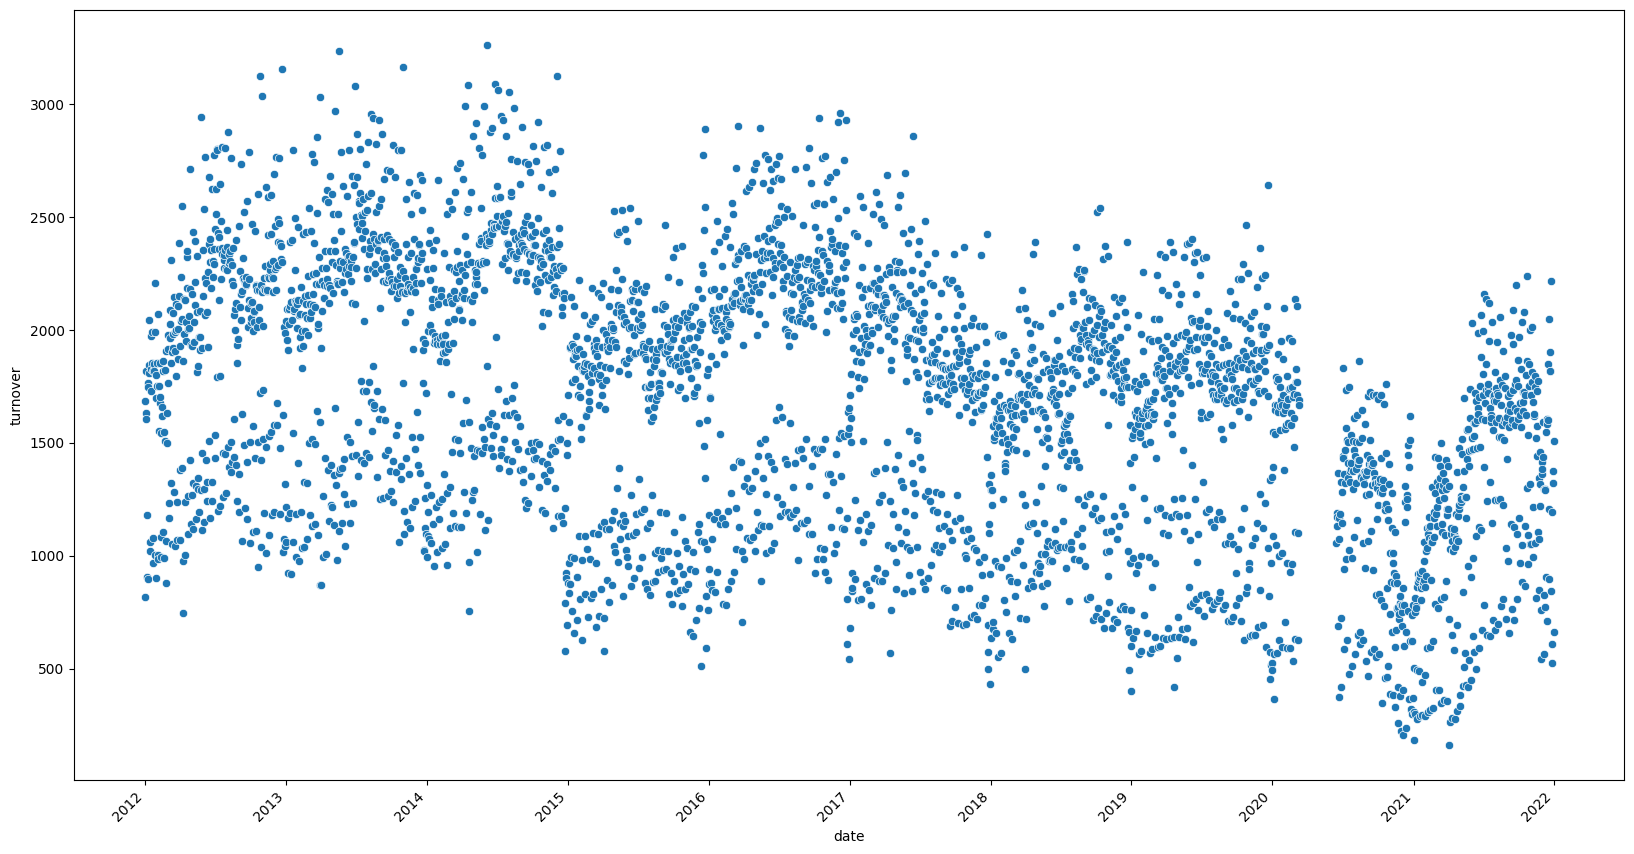

In [75]:
# for example, "Savoury Snack" in "Metro" has a sudden drop in sales after 2014 which is likely due to e.g. a change in categories or decrease in store size or something else which cannot be accounted for by a model
plt.figure(figsize = (20,10))
sns.scatterplot(data =df_full[(df_full["branch"] == "Metro") & (df_full["product"] == "Savoury Snack")], x = "date", y = "turnover")
plt.xticks(rotation=45, horizontalalignment="right");

In [76]:
# create new column for adjusted turnover
df_full["turnover_adjusted"] = df_full["turnover"].copy()

def mean_shift(df_full, branches, products, date1, date2, date3, date4, date5, date6):
    
    for br in branches:
        for pr in products:
            # multiplying with the respective mean shift compared to timeframe between date1 and date2 and date3 and date4
            mean_before = df_full["turnover"][(df_full["product"] == pr) & (df_full["branch"] == br) &
            (((df_full["date"] >= date1) & 
            (df_full["date"] < date2)) | ((df_full["date"] >= date3) & 
            (df_full["date"] < date4)))].mean()
            mean_of_interest = df_full["turnover"][(df_full["product"] == pr) & (df_full["branch"] == br) &
            (df_full["date"] >= date5) & 
            (df_full["date"] < date6)].mean()
            df_full["turnover_adjusted"][(df_full["product"] == pr) & (df_full["branch"] == br) &
            (df_full["date"] >= date5) & 
            (df_full["date"] < date6)] = df_full["turnover"][(df_full["product"] == pr) & (df_full["branch"] == br) &
            (df_full["date"] >= date5) & 
            (df_full["date"] < date6)] * mean_before / mean_of_interest
    return df_full

df_full = mean_shift(df_full, branches = ["Metro", "Train_Station", "Center"], products = ["Wheat Rolls"], 
date1 = pd.to_datetime("2016-05-01"), date2 = pd.to_datetime("2016-07-30"), 
date3 = pd.to_datetime("2017-05-01"), date4 = pd.to_datetime("2017-07-30"),
date5 = pd.to_datetime("2018-05-01"), date6 = pd.to_datetime("2018-07-30"))

df_full = mean_shift(df_full, branches = ["Train_Station"], products = ["Wheat Rolls"], 
date1 = pd.to_datetime("2016-01-01"), date2 = pd.to_datetime("2016-12-31"), 
date3 = pd.to_datetime("2017-01-01"), date4 = pd.to_datetime("2017-12-31"),
date5 = pd.to_datetime("2012-07-01"), date6 = pd.to_datetime("2015-12-31"))

df_full = mean_shift(df_full, branches = ["Metro"], products = ["Brown Bread"], 
date1 = pd.to_datetime("2016-01-01"), date2 = pd.to_datetime("2016-12-31"), 
date3 = pd.to_datetime("2017-01-01"), date4 = pd.to_datetime("2017-12-31"),
date5 = pd.to_datetime("2018-08-01"), date6 = pd.to_datetime("2020-03-11"))

df_full = mean_shift(df_full, branches = ["Train_Station"], products = ["Savoury Snack"], 
date1 = pd.to_datetime("2016-01-01"), date2 = pd.to_datetime("2016-12-31"), 
date3 = pd.to_datetime("2017-01-01"), date4 = pd.to_datetime("2017-12-31"),
date5 = pd.to_datetime("2012-01-01"), date6 = pd.to_datetime("2015-09-30"))

df_full = mean_shift(df_full, branches = ["Train_Station"], products = ["Savoury Snack"], 
date1 = pd.to_datetime("2016-10-01"), date2 = pd.to_datetime("2016-12-31"), 
date3 = pd.to_datetime("2017-10-01"), date4 = pd.to_datetime("2017-12-31"),
date5 = pd.to_datetime("2015-10-01"), date6 = pd.to_datetime("2015-12-31"))

df_full = mean_shift(df_full, branches = ["Metro"], products = ["Savoury Snack"], 
date1 = pd.to_datetime("2016-01-01"), date2 = pd.to_datetime("2016-12-31"), 
date3 = pd.to_datetime("2017-01-01"), date4 = pd.to_datetime("2017-12-31"),
date5 = pd.to_datetime("2012-01-01"), date6 = pd.to_datetime("2014-12-31"))

/var/folders/jq/n1sfhk3x081brcshwchpd9640000gn/T/ipykernel_21203/2652123332.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full["turnover_adjusted"][(df_full["product"] == pr) & (df_full["branch"] == br) &
/var/folders/jq/n1sfhk3x081brcshwchpd9640000gn/T/ipykernel_21203/2652123332.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full["turnover_adjusted"][(df_full["product"] == pr) & (df_full["branch"] == br) &
/var/folders/jq/n1sfhk3x081brcshwchpd9640000gn/T/ipykernel_21203/2652123332.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in th

/Users/burkhardtflemer/Desktop/neuefische/meteo-bakery/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/burkhardtflemer/Desktop/neuefische/meteo-bakery/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/burkhardtflemer/Desktop/neuefische/meteo-bakery/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/burkhardtflemer/Desktop/neuefische/meteo-bakery/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .ite

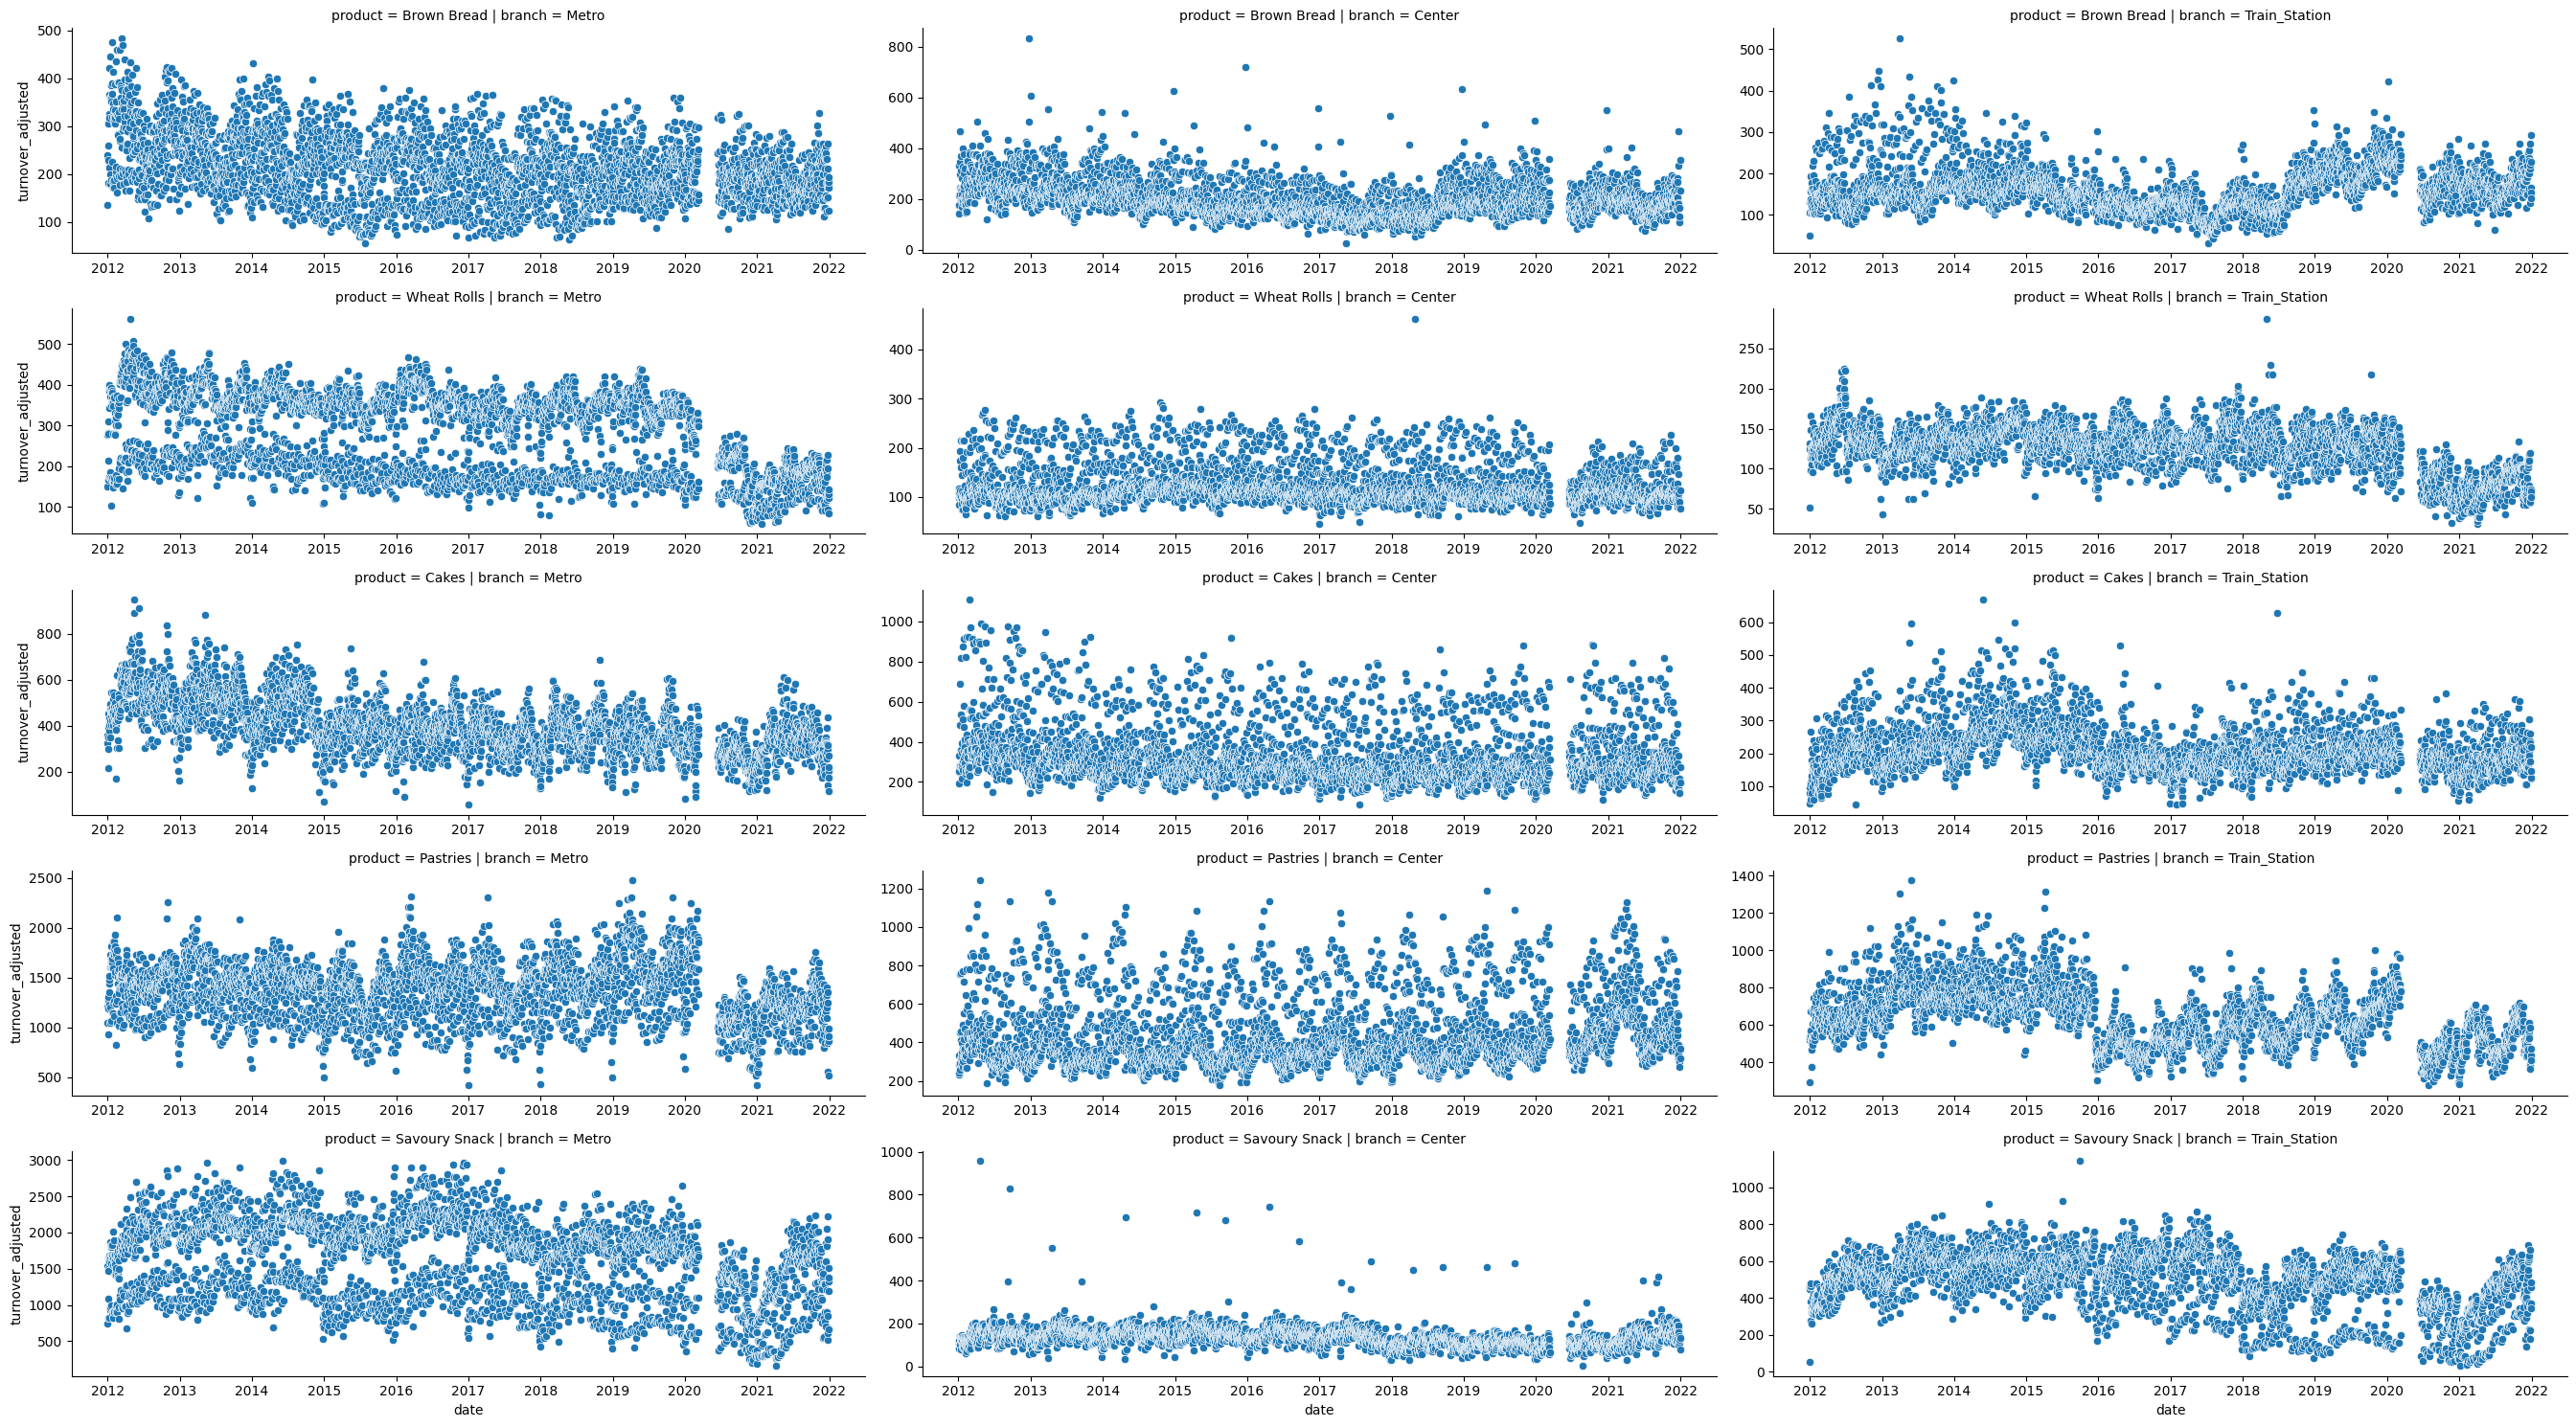

In [77]:
# after adjustment
g = sns.FacetGrid(data = df_full, row = "product", col = "branch", aspect = 3, 
sharex = False, sharey = False)
g.map(sns.scatterplot, "date", "turnover_adjusted")
plt.savefig("../plots/sales.overview.perbranchandproduct.adjusted.png");

### merge with weather statistics

In [78]:
weather_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 77 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  3653 non-null   object 
 1   temp_mean             3653 non-null   float64
 2   temp_min              3653 non-null   float64
 3   temp_max              3653 non-null   float64
 4   temp_std              3653 non-null   float64
 5   feels_like_mean       3653 non-null   float64
 6   feels_like_min        3653 non-null   float64
 7   feels_like_max        3653 non-null   float64
 8   feels_like_std        3653 non-null   float64
 9   pressure_mean         3653 non-null   float64
 10  pressure_min          3653 non-null   int64  
 11  pressure_max          3653 non-null   int64  
 12  pressure_std          3653 non-null   float64
 13  humidity_mean         3653 non-null   float64
 14  humidity_min          3653 non-null   int64  
 15  humidity_max         

In [79]:
# parse date to datetime
weather_stats['date'] = pd.to_datetime(weather_stats['date'])

In [80]:
# merge dataframes
df_joined = df_full.merge(weather_stats, on='date', how='left')

In [81]:
df_joined.head(20)

,date,branch,product,turnover,year,month,week,day_of_month,day_of_week,school_holiday,...,clouds_mean_dev,wind_speed_mean_dev,wind_dir_x_mean_dev,wind_dir_y_mean_dev,rain_1h_mean_dev,snow_1h_mean_dev,visibility_mean_dev,temp_mean_change,pressure_mean_change,humidity_mean_change
0,2012-01-01,Metro,Brown Bread,134.735759,2012,1,52,1,6,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01-01,Metro,Wheat Rolls,150.104897,2012,1,52,1,6,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-01-01,Metro,Cakes,322.635866,2012,1,52,1,6,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-01-01,Metro,Pastries,1047.327119,2012,1,52,1,6,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-01-01,Metro,Savoury Snack,816.663466,2012,1,52,1,6,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2012-01-01,Center,Brown Bread,NaN,2012,1,52,1,6,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2012-01-01,Center,Wheat Rolls,NaN,2012,1,52,1,6,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2012-01-01,Center,Cakes,NaN,2012,1,52,1,6,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2012-01-01,Center,Pastries,NaN,2012,1,52,1,6,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2012-01-01,Center,Savoury Snack,NaN,2012,1,52,1,6,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
# create dummies for general weather
# merging and cleaning condition column
df_joined["general_w"] = df_joined["condition_total"]
df_joined["general_w"][df_joined["general_w"] == "['rainy' 'snowy']"] = "snowy"
df_joined["general_w"][df_joined["general_w"] == "['clear' 'cloudy' 'rainy']"] = "rainy"
df_joined["general_w"][df_joined["general_w"] == "['clear' 'cloudy']"] = "cloudy"
df_joined["general_w"][df_joined["general_w"] == "['clear' 'sormy']"] = "stormy"
df_joined["general_w"][df_joined["general_w"] == "['cloudy' 'rainy']"] = "rainy"
df_joined["general_w"][df_joined["general_w"] == "['cloudy' 'snowy']"] = "snowy"
df_joined["general_w"][df_joined["general_w"] == "['cloudy' 'rainy' 'snowy']"] = "snowy"
df_joined["general_w"][df_joined["general_w"] == "['foggy' 'rainy']"] = "foggy"
df_joined["general_w"][df_joined["general_w"] == "['clear' 'cloudy' 'snowy']"] = "snowy"
df_joined["general_w"][df_joined["general_w"] == "['cloudy' 'rainy' 'stormy]"] = "stormy"
df_joined["general_w"][df_joined["general_w"] == "['clear' 'foggy']"] = "foggy"
df_joined["general_w"][df_joined["general_w"] == "['clear' 'cloudy' 'foggy']"] = "foggy"
df_joined["general_w"][df_joined["general_w"] == "['clear' 'rainy']"] = "rainy"
df_joined["general_w"][df_joined["general_w"] == "['cloudy' 'foggy' 'rainy']"] = "foggy"
df_joined["general_w"][df_joined["general_w"] == "['foggy' 'snowy']"] = "foggy"
df_joined["general_w"][df_joined["general_w"] == "['clear' 'stormy']"] = "stormy"
df_joined["general_w"][df_joined["general_w"] == "['cloudy' 'foggy']"] = "foggy"
df_joined["general_w"][df_joined["general_w"] == "['cloudy' 'rainy' 'stormy']"] = "stormy"
df_joined["general_w"].unique()
# for the moment I just fill NaNs with previous value. 
df_joined["general_w"].fillna(method="ffill", inplace=True)
# then dummies for general weather
dummies = pd.get_dummies(df_joined['general_w'], prefix="general_w")
df_joined = df_joined.join(dummies)

# column for weekend or not
df_joined["weekend"] = df_joined.day_of_week.isin([5, 6]).astype("float")

# create dummies for school holidays
dummies = pd.get_dummies(df_joined['s_hol_name'], prefix="sh")
df_joined = df_joined.join(dummies)

# and dummies for public holidays
dummies = pd.get_dummies(df_joined['p_hol_name'], prefix="ph")
df_joined = df_joined.join(dummies)

# get temperature change from one to another day
tmp_temp = df_joined.temp_mean.copy()
tmp_temp_day_before = np.array(tmp_temp[15:]) - np.array(tmp_temp[:-15])
tmp_temp = list(chain.from_iterable([list(np.repeat("NaN",15)), list(tmp_temp_day_before)]))
df_joined["temp_shift"] = tmp_temp

# get pressure change as proxy for change of weather
tmp_pr = df_joined.pressure_mean.copy()
tmp_pr_day_before = np.array(tmp_pr[15:]) - np.array(tmp_pr[:-15])
tmp_pr = list(chain.from_iterable([list(np.repeat("NaN",15)), list(tmp_pr_day_before)]))
df_joined["pressure_shift"] = tmp_pr

# tomorrows weather
tmp_weather = df_joined["general_w"].copy()
tmp_next_day = list(chain.from_iterable([list(tmp_weather[15:]), list(np.repeat("NaN",15))]))
df_joined["tomorrows_weather"] = tmp_next_day

# then dummies for tomorrows weather
dummies = pd.get_dummies(df_joined['tomorrows_weather'], prefix="tw")
df_joined = df_joined.join(dummies)

/var/folders/jq/n1sfhk3x081brcshwchpd9640000gn/T/ipykernel_21203/2997354504.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_joined["general_w"][df_joined["general_w"] == "['rainy' 'snowy']"] = "snowy"
/var/folders/jq/n1sfhk3x081brcshwchpd9640000gn/T/ipykernel_21203/2997354504.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_joined["general_w"][df_joined["general_w"] == "['clear' 'cloudy' 'rainy']"] = "rainy"
/var/folders/jq/n1sfhk3x081brcshwchpd9640000gn/T/ipykernel_21203/2997354504.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docu

In [83]:
# export combined data to csv file
df_joined.to_csv('../data/data_combined.csv', index=False)